# Data Prep

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from PIL import Image
import skimage.measure
import os
import cv2

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("test.csv")

In [3]:
BATCH_SIZE = 4
IMG_SIZE = 224
NUM_CLASSES = train_df["diagnostic"].nunique()

In [4]:
datagen = ImageDataGenerator (
    rescale = 1/255.,
)

training_generator = datagen.flow_from_dataframe (
    train_df,
    x_col = "filename",
    y_col = "diagnostic",
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

val_generator = datagen.flow_from_dataframe (
    val_df,
    x_col = "filename",
    y_col = "diagnostic",
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

Found 1838 validated image filenames belonging to 6 classes.
Found 460 validated image filenames belonging to 6 classes.


In [5]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(training_generator.classes), 
    y = training_generator.classes)
class_weights = dict(zip(np.unique(training_generator.classes), class_weights))
class_weights

{0: 0.5245433789954338,
 1: 0.4531558185404339,
 2: 7.2936507936507935,
 3: 1.570940170940171,
 4: 2.002178649237473,
 5: 1.6294326241134751}

In [6]:
classes = train_df["diagnostic"].unique()

# Gradcam

In [7]:
@tf.function
def normalize(heatmap):
    num = heatmap - tf.reduce_min(heatmap)
    deno = (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
    if deno == 0:
        return heatmap
    heatmap = num / deno
    return heatmap

In [8]:
@tf.function
def compute_gradcam_map(model, image, eps=1e-8):
    gradModel = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(get_last_layer_name(model)).output, model.output]
    )
    gradModel.layers[-1].activation = tf.keras.activations.linear

    with tf.GradientTape(persistent = True) as tape:
        input_image = tf.cast(image, tf.float32)
        convOutputs, predictions = gradModel(input_image, training=False)
        classid = tf.argmax(predictions[0])
        loss = predictions[:, classid]

    grads = tape.gradient(loss, convOutputs)

    pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

    convOutputs = convOutputs[0]
    heatmap = convOutputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.image.resize(heatmap[tf.newaxis, ..., tf.newaxis], [IMG_SIZE, IMG_SIZE])
    heatmap = tf.squeeze(heatmap)

    heatmap = normalize(heatmap)
    return heatmap

In [9]:
@tf.function
def get_last_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return []

In [10]:
@tf.function
def generate_gradcam_batch(imgs, global_model, threshold):

    fused_heatmaps = []
    for image in imgs:
        heatmap = compute_gradcam_map(global_model, tf.expand_dims(image, axis=0))
        fused_heatmaps.append(heatmap)

    # Generate mask from combination
    fused_heatmaps = tf.convert_to_tensor(fused_heatmaps, tf.float32)
    binary_masks = tf.where(fused_heatmaps > threshold, 1, 0)

    # Pool the pixels to look at the neighbourhood of the bright pixel instead of just the bright pixel alone
    pooled_bin_mask = tf.nn.max_pool2d(binary_masks[:, :, :, tf.newaxis], ksize=(30, 30), strides=(1, 1), padding="SAME")[:, :, :, 0]

    pool_binary_masks = tf.stack([pooled_bin_mask] * 3, axis = -1)
    pool_binary_masks = tf.cast(pool_binary_masks, tf.float32)    
    return tf.multiply(pool_binary_masks, imgs)

In [11]:
@tf.function
def generate_gradcam_batch_withheat(imgs, global_model, threshold):

    fused_heatmaps = []
    for image in imgs:
        heatmap = compute_gradcam_map(global_model, tf.expand_dims(image, axis=0))
        fused_heatmaps.append(heatmap)

    # Generate mask from combination
    fused_heatmaps = tf.convert_to_tensor(fused_heatmaps, tf.float32)
    binary_masks = tf.where(fused_heatmaps > threshold, 1, 0)
    
    # Pool the pixels to look at the neighbourhood of the bright pixel instead of just the bright pixel alone
    pooled_bin_mask = tf.nn.max_pool2d(binary_masks[:, :, :, tf.newaxis], ksize=(30, 30), strides=(1, 1), padding="SAME")[:, :, :, 0]

    pool_binary_masks = tf.stack([pooled_bin_mask] * 3, axis = -1)
    pool_binary_masks = tf.cast(pool_binary_masks, tf.float32)
    return fused_heatmaps, pool_binary_masks, tf.multiply(pool_binary_masks, imgs)

# Train Global branch - Xception

In [12]:
from tensorflow.keras.applications.xception import Xception

In [13]:
def build_base_model():

    backbone_model = Xception(
        include_top=False,
        weights="imagenet",
        input_tensor=tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    )

    pooling  = tf.keras.layers.GlobalMaxPooling2D()(backbone_model.output)
    
    dense = tf.keras.layers.Dense(units = 1024, kernel_regularizer= tf.keras.regularizers.l2(0.0001))(pooling)
    batch_norm = tf.keras.layers.BatchNormalization()(dense)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm)
    
    classifier = tf.keras.layers.Dense(units = NUM_CLASSES, activation = 'softmax')(leaky_relu)
    model = tf.keras.models.Model(inputs = backbone_model.input, outputs = classifier)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics = ['accuracy'])
    
    # Added to improve gradcam output
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.ZeroPadding2D):
            continue
        layer.padding = "same"
            
    return model

In [14]:
global_model = build_base_model()

In [15]:
global_model.load_weights("models_xception_gradcam/Global/10_1.383_0.654.h5")

In [ ]:
EPOCHS = 40

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-6)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models_xception_gradcam/Global/best_model.h5', monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)
mycallbacks = [earlystop, learning_rate_reduction,checkpoint]

In [ ]:
history = global_model.fit_generator(
    training_generator,
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks = mycallbacks,
    class_weight=class_weights
)

In [ ]:
# Plot accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Plot loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
val_loss, val_accuracy = global_model.evaluate(val_generator)
print(val_loss, val_accuracy)

In [ ]:
global_model.save_weights(f"models_xception_gradcam/Global/50_{val_loss:.3f}_{val_accuracy:.3f}.h5")

# Build local branch

In [16]:
local_model = build_base_model()

In [17]:
local_model.load_weights("models_xception_gradcam/Global/10_1.383_0.654.h5")

# Visualize GradCAM

In [32]:
images, labels = training_generator.next()

In [33]:
heatmaps, masks, out_imgs = generate_gradcam_batch_withheat(images, global_model, 0.75)

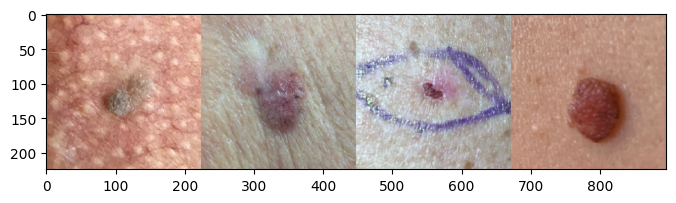

In [34]:
# Input images
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack(images), cmap="jet")

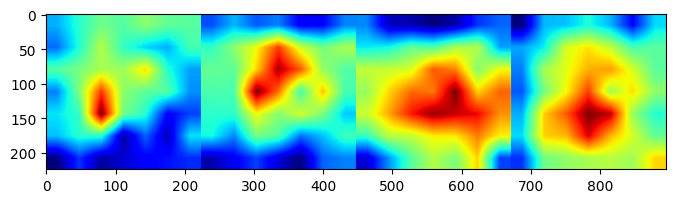

In [35]:
# Attention maps
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack([normalize(img) for img in heatmaps]), cmap="jet")

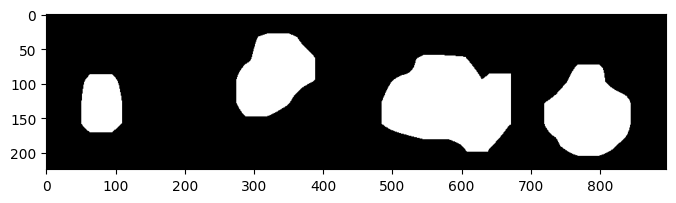

In [36]:
# Masks
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack([normalize(img) for img in masks]), cmap="jet")

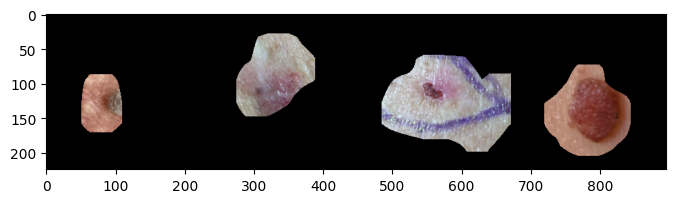

In [37]:
# Local input
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack(out_imgs), cmap="jet")

# Train Fusion


In [18]:
# Change global model structure before continuing

In [19]:
def build_new_model(old_model):
    model = tf.keras.models.clone_model(old_model)
    model.build(old_model.inputs[0].shape)
    model.set_weights(old_model.get_weights())
    
    # Change layer index according to model
    # Should point the the final pooling layer
    model_pool = model.get_layer(index=132).output
    new_model = tf.keras.models.Model(inputs = model.inputs, outputs = model.outputs + [model_pool])
    return new_model

In [20]:
new_global = build_new_model(global_model)

In [21]:
new_local = build_new_model(local_model)

In [22]:
def build_merge_model():
    '''
    Building Merging Model for Custom Loop Implementation
    '''
    # Change input dimension according to pooling output of backbone
    inp1 = tf.keras.Input((2048,))
    inp2 = tf.keras.Input((2048,))
    conc = tf.keras.layers.Concatenate()([inp1,inp2])
    fc = tf.keras.layers.Dense(NUM_CLASSES,activation="softmax")(conc)
    merge_model = tf.keras.models.Model(inputs = [inp1,inp2],outputs = fc)
    return merge_model
merge_model = build_merge_model()

In [23]:
new_local.load_weights("models_xception_gradcam/Local/model_11_1.82_0.6_1.72_0.72.h5")
merge_model.load_weights("models_xception_gradcam/Merge/model_11_1.82_0.6_1.72_0.72.h5")

In [ ]:
@tf.function
def train_step(x,y,new_global, new_local):
    batch_weights = [class_weights[tf.argmax(label).numpy()] for label in y]
    with tf.GradientTape(persistent=True) as tape:
        g_out, g_pool = new_global(x,training = False)
        gradcam_batch = generate_gradcam_batch(x,global_model,THRESHOLD)
        l_out, l_pool = new_local(gradcam_batch,training= True)
        local_loss = loss(y, l_out, sample_weight=batch_weights)
        fout = merge_model([g_pool,l_pool],training=True)
        merge_loss = loss(y, fout, sample_weight=batch_weights)       

    train_acc_metric_local.update_state(y, l_out)
    train_acc_metric_merge.update_state(y, fout)

    local_grads = tape.gradient(local_loss, new_local.trainable_weights)
    merge_grads = tape.gradient(merge_loss,merge_model.trainable_weights)

    optimizer.apply_gradients(zip(local_grads,new_local.trainable_weights))
    optimizer.apply_gradients(zip(merge_grads,merge_model.trainable_weights))

    return local_loss, merge_loss

In [ ]:
@tf.function
def val_step(x,y,new_global, new_local):
    g_out,g_pool = new_global(x,training = False)
    gradcam_batch = generate_gradcam_batch(x,global_model,THRESHOLD)
    l_out,l_pool = new_local(gradcam_batch,training= False)
    fout = merge_model([g_pool,l_pool],training=False)
    
    val_acc_metric_local.update_state(y, l_out)
    val_acc_metric_merge.update_state(y, fout)
    
    local_loss = loss(y, l_out)
    merge_loss = loss(y, fout)
    return local_loss, merge_loss

In [ ]:
def validate(e):
    for vs in range(STEPS_PER_EPOCH_VAL):
        print(f"\rVal step:{vs+1}/{STEPS_PER_EPOCH_VAL}",end="")
        x_val,y_val = val_generator.next()
        v_loss_local, v_loss_merge = val_step(x_val,y_val,new_global, new_local)
    print(f"Validation for Epoch {e} Local Loss = {v_loss_local.numpy():.4f} Local Acc = {val_acc_metric_local.result().numpy():.4f} Merge Loss = {v_loss_merge:.4f} Merge Acc = {val_acc_metric_merge.result().numpy():.4f}")
    returnval = [v_loss_local.numpy(), val_acc_metric_local.result().numpy(), v_loss_merge.numpy(), val_acc_metric_merge.result().numpy()]
    val_acc_metric_local.reset_states()
    val_acc_metric_merge.reset_states()
    return returnval

In [ ]:
def train():
    for s in range(STEPS_PER_EPOCH):
        print(f"\rStep: {s+1}/{STEPS_PER_EPOCH}",end="")
        x,y = training_generator.next()
        t_loss_local, t_loss_merge = train_step(x,y,new_global, new_local)

        if s%10 ==0:
            print(f" Epoch {e} Step {s} Local Loss = {t_loss_local} Local Acc = {train_acc_metric_local.result().numpy()} Merge Loss = {t_loss_merge} Merge Acc = {train_acc_metric_merge.result().numpy()}")
            train_acc_metric_local.reset_states()            
            train_acc_metric_merge.reset_states()

In [ ]:
START_EPOCH = 0
EPOCHS = 70
THRESHOLD=0.75
STEPS_PER_EPOCH = training_generator.samples//BATCH_SIZE
STEPS_PER_EPOCH_VAL = val_generator.samples//BATCH_SIZE

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
train_acc_metric_local = tf.keras.metrics.CategoricalAccuracy()
train_acc_metric_merge = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric_local =tf.keras.metrics.CategoricalAccuracy()
val_acc_metric_merge =tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
for e in range(START_EPOCH, EPOCHS):
    print(f"Epoch: {e}/{EPOCHS}")

    train()
    result = validate(e)
    result = [str(round(x, 2)) for x in result]
    merge_model.save_weights(f"models_xception_gradcam/Merge/model_{e}_{'_'.join(result)}.h5")
    new_local.save_weights(f"models_xception_gradcam/Local/model_{e}_{'_'.join(result)}.h5")

# Metrics

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score

In [25]:
def get_metrics(prediction_function):
    y_pred = []
    y_pred_max = []
    y_true = []

    num_steps = val_generator.samples//BATCH_SIZE

    for i in range(num_steps):
        print(f"\r{i}/{num_steps}", end="")
        x, y = val_generator.next()
        y_pred_batch = prediction_function(x, y)
        y_pred_batch/= tf.reshape(
            tf.reduce_sum(y_pred_batch, axis=1), 
            (-1, 1)
        )
        y_pred += list(y_pred_batch.numpy())
        y_pred_max += list(tf.argmax(y_pred_batch, axis=1).numpy())
        y_true += list(tf.argmax(y, axis=1).numpy())
    
    print()
    acc = accuracy_score(y_true, y_pred_max)
    print("Accuracy: ", acc)
    
    precision = precision_score(y_true, y_pred_max, average='weighted')
    print("Precision: ", precision)
    
    recall = recall_score(y_true, y_pred_max, average='weighted')
    print("Recall: ", recall)
    
    f1 = f1_score(y_true, y_pred_max, average='weighted')
    print("F1: ", f1)

    auc = roc_auc_score(y_true, y_pred, average='weighted', multi_class='ovr')
    print("AUC: ", auc)

In [26]:
def pred_global(images, labels):
    return global_model(images, training=False)

In [27]:
def pred_local(images, labels):
    g_out,g_pool = new_global(images,training = False)
    gradcam_batch = generate_gradcam_batch(images,global_model,0.75)
    l_out,l_pool = new_local(gradcam_batch,training= False)
    return l_out

In [28]:
def pred_fusion(images, labels):
    g_out,g_pool = new_global(images,training = False)
    gradcam_batch = generate_gradcam_batch(images,global_model,0.75)
    l_out,l_pool = new_local(gradcam_batch,training= False)
    y_pred = merge_model([g_pool,l_pool],training=False)
    return y_pred

In [29]:
get_metrics(pred_global)

114/115
Accuracy:  0.6543478260869565
Precision:  0.711208205421099
Recall:  0.6543478260869565
F1:  0.6673469806059008
AUC:  0.8759679025471129


In [30]:
get_metrics(pred_local)

114/115
Accuracy:  0.6021739130434782
Precision:  0.6409797176548119
Recall:  0.6021739130434782
F1:  0.6137969349177247
AUC:  0.832360215938046


In [31]:
get_metrics(pred_fusion)

114/115
Accuracy:  0.717391304347826
Precision:  0.7084549216849718
Recall:  0.717391304347826
F1:  0.7060057436051524
AUC:  0.893479830350651
